In [1]:
import sys
sys.path.insert(0,'../..')
from prior_ratio import GaussianChieffToIASPriorRatio, InjectionPriortoIASPriorRatio, \
                                IASPriortoInjectionPriorRatio
from population_likelihood import PopulationLikelihood

In [2]:
import pandas as pd
import glob
import numpy as np
import corner
import matplotlib.pyplot as plt

In [3]:
from cogwheel.prior import Prior, UniformPriorMixin, IdentityTransformMixin
import cogwheel.sampling as sampling
from cogwheel.posterior import Posterior

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
lal.swig_redirect_standard_output_error(False)

/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/new_population_inference/../../cogwheel/waveform.py:6: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


True

## Create Likelihood Object

In [4]:
# Create PriorRatio objects
pop_to_ias = GaussianChieffToIASPriorRatio()
injprior_to_ias = InjectionPriortoIASPriorRatio()
ias_to_injprior = IASPriortoInjectionPriorRatio()

In [5]:
# read the pe_samples, injections_summary from file
pe_samples_root = '../population_inference/data/PE_samples_all_jacobian'
pe_samples_fnames = glob.glob(pe_samples_root+'/*')[:10]
pe_samples=[]
for fname in pe_samples_fnames:
    pe_samples.append(pd.read_feather(fname))
recovered_injections_df = pd.read_pickle('../population_inference/data/injections_summary.pkl')
injections_summary_dict = {'Ninj':20000, 'recovered_injections':recovered_injections_df}

In [47]:
# max(recovered_injections_df['m2_source']), min(recovered_injections_df['m2_source'])

In [48]:
# max(recovered_injections_df['m2_source']), min(recovered_injections_df['m2_source'])

In [49]:
# max(recovered_injections_df['m1']), min(recovered_injections_df['m1'])

In [6]:
pastro_ref = np.ones(10)
rate0=90

In [7]:
likelihood_obj = PopulationLikelihood(pop_to_ias, injprior_to_ias, ias_to_injprior, pe_samples, pastro_ref, 
                                 injections_summary_dict, rate0)

In [8]:
hyperparams_dic = {'rate':70, 'chieff_mean':0, 'chieff_std':0.4}
likelihood_obj.lnlike(hyperparams_dic)

-18.324540708209874

In [12]:
# %%prun
# likelihood_obj.lnlike(hyperparams_dic)

In [22]:
#likelihood_obj._compute_w_arr({'chieff_mean':0, 'chieff_std':0.4})

In [9]:
likelihood_obj._compute_vt({'chieff_mean':0, 'chieff_std':0.4})

0.2738350744162968

## Create prior object

In [25]:
class GaussianChieffHyperPrior(IdentityTransformMixin, UniformPriorMixin, Prior):
    standard_params = ['rate','chieff_mean', 'chieff_sigma']
    range_dic={'rate':(10, 1000),'chieff_mean':(-1, 1), 'chieff_std':(0.1,2)}

In [16]:
gaussianchieffprior = GaussianChieffHyperPrior()

## Create posterior and sample

In [17]:
post = Posterior(gaussianchieffprior, likelihood_obj)

In [18]:
output_file_path = '/home/isha/PopulationSelectionEffects/output/new_pop_inf8'
pym = sampling.PyMultiNest(post)
pym.run_kwargs = {'n_iter_before_update': 1000,'n_live_points': 256,'evidence_tolerance': 0.1}
# perform the pe now
pym.run(output_file_path)

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  256
 dimensionality =    3
 *****************************************************

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.
 ln(ev)=   37.787170506949970      +/-  0.14424826102480784     
 Total Likelihood Evaluations:         4404
 Sampling finished. Exiting MultiNest


In [ ]:
samples = pd.read_feather(output_file_path+'/samples.feather')

In [ ]:
samples

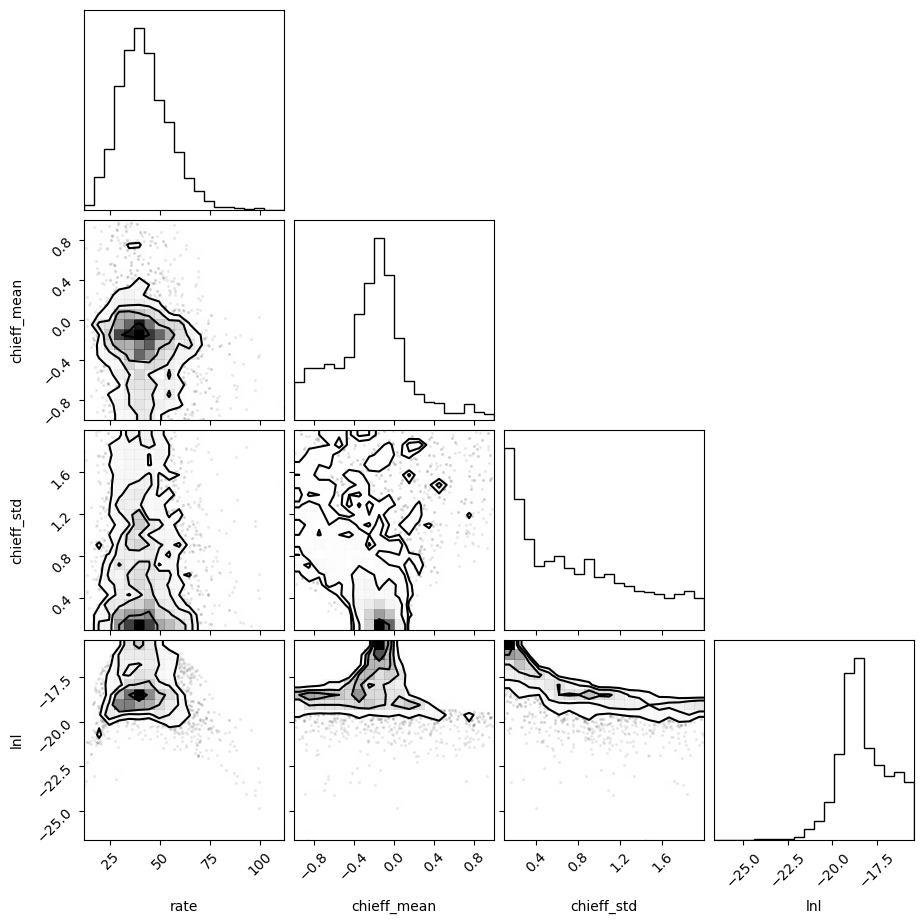

In [18]:
corner.corner(samples, labels=samples.columns);

## Compare old and new likelihoods

In [ ]:
# read in samples and saved w_i and vt arrays from new_pop_inf7

In [10]:
output_dir = '/home/isha/PopulationSelectionEffects/output/new_pop_inf7'
samples = pd.read_feather(output_dir+'/samples.feather')
w_i_old = np.load(output_dir+'/w_i_old.npy')
vt_old = np.load(output_dir+'/vt_old.npy')

In [11]:
#compute vt_new, w_i_new using likelihood object here

In [12]:
w_i_new = []
vt_new = []
for i in range(len(samples[0:5])):
    row = samples.iloc[i]
    shape_hyperparams = {'chieff_mean':row['chieff_mean'] , 'chieff_std':row['chieff_std']}
    w_i_new.append(likelihood_obj._compute_w_arr(shape_hyperparams))
    vt_new.append(likelihood_obj._compute_vt(shape_hyperparams))

In [13]:
w_i_new = np.array(w_i_new)
vt_new = np.array(vt_new)
w_i_new10 = w_i_new[:,:10]

In [15]:
# plt.scatter(np.log(np.sum(w_i_new10,axis=-1)), np.log(np.sum(w_i_old, axis=-1)), s=2)
# plt.plot(np.linspace(1.5, 3.5), np.linspace(1.5, 3.5) - 4)
# plt.gca().set_aspect('equal')

In [18]:
w_i_old[0]

array([0.0117693 , 0.00640077, 0.0022879 , 0.01166074,
       0.00690927, 0.00737989, 0.00564977, 0.00321283,
       0.00371598, 0.00342239])

In [19]:
w_i_new[0]

array([1.04469091, 1.01698061, 0.79340111, 1.11965847,
       0.99295223, 0.99263239, 0.64527303, 0.91211249,
       0.98355399, 1.06714251])

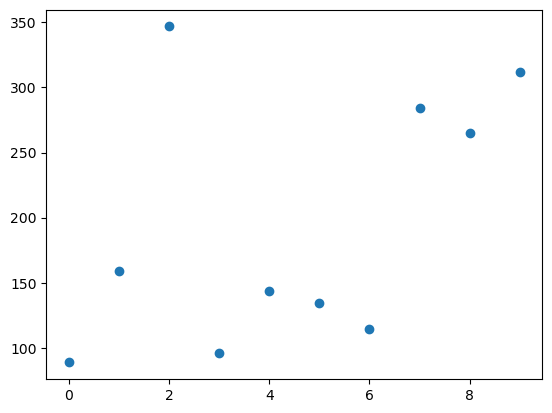

In [20]:
plt.scatter(range(10), w_i_new[0]/w_i_old[0])

In [30]:
mask_wrong = np.where(np.log(np.sum(w_i_old, axis=-1))<-2.5)
inds_wrong = mask_wrong[0]

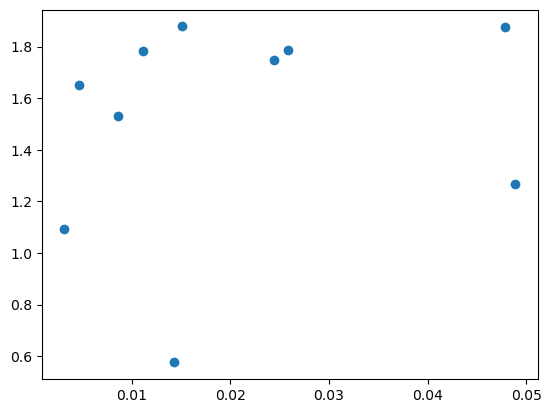

In [35]:
plt.scatter(w_i_old[mask_agree[0][0]], w_i_new[mask_agree[0][0]])

In [31]:
# plt.scatter(w_i_old[inds_wrong[0]]
plt.scatter(np.log(np.sum(w_i_new10,axis=-1)), np.log(np.sum(w_i_old, axis=-1)))

array([0.0117693 , 0.00640077, 0.0022879 , 0.01166074,
       0.00690927, 0.00737989, 0.00564977, 0.00321283,
       0.00371598, 0.00342239])

In [33]:
w_i_old[inds_wrong[mask_agree[0][0]]]

array([0.0156307 , 0.00848982, 0.00266758, 0.01513896,
       0.00918133, 0.00963715, 0.00744074, 0.00417892,
       0.00476392, 0.00446703])

In [23]:
np.sum(w_i_old, axis=-1)

array([0.06240884, 0.20385576, 0.08159613, ..., 0.26908204,
       0.32499613, 0.29087238])

In [18]:
mask_disagree = np.where(np.log(np.sum(w_i_new10,axis=-1))<2.70)
mask_agree = np.where(np.log(np.sum(w_i_new10,axis=-1))>2.70)

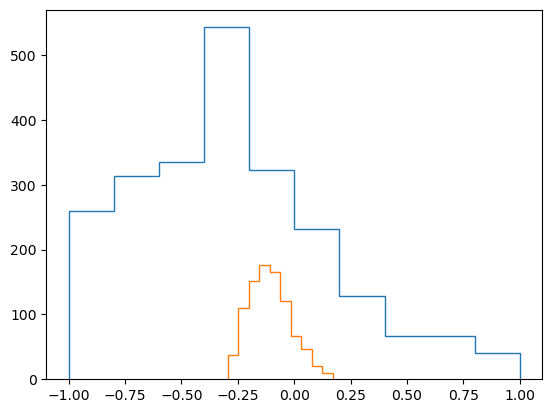

In [19]:
plt.hist(samples.iloc[mask_disagree]['chieff_mean'], histtype='step');
plt.hist(samples.iloc[mask_agree]['chieff_mean'], histtype='step');
#plt.hist(samples.iloc[mask]['chieff_std'], histtype='step');

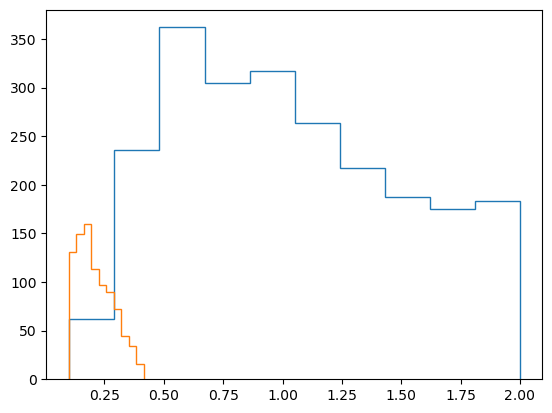

In [20]:
plt.hist(samples.iloc[mask_disagree]['chieff_std'], histtype='step');
plt.hist(samples.iloc[mask_agree]['chieff_std'], histtype='step');
#plt.hist(samples.iloc[mask]['chieff_std'], histtype='step');

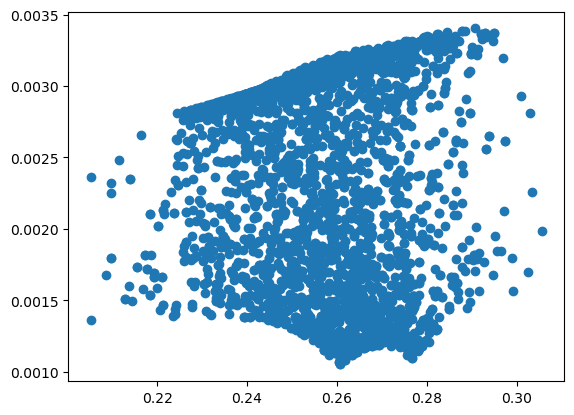

In [17]:
plt.scatter(vt_new, vt_old)

## compare w_i in new and old

In [ ]:
from cogwheel.population_inference.